# SkmiLit NLP Project

The purpose of this noebook is to build an NLP model to make reading medical abstracts easier.

The paper is available <a href="https://arxiv.org/abs/1710.06071">here</a>

The model they've used to achieve their best results is <a href="https://arxiv.org/pdf/1612.05251.pdf">here</a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-b233f2b2-440f-7bc8-514c-cd78f9c5491f)


## Get Data

Since we'll be replicating the paper above (PubMed 200K RCT), we'll download the dataset they used through the author's github <a href="https://github.com/Franck-Dernoncourt/pubmed-rct">here</a>

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


`dev.txt` means nothing more than a validation set. Rest are self-explanatory.

In [ ]:

# Start our experiments using the 20k datasets with numbers replaced by @-sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

# check all the filenames in the target dir        
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data

With the text data in hand, it's time to preprocess it and visualize it.

In [ ]:
# Create a function to read the lines of document
def get_lines(filename):
  """
  Reads a text filename and returns the lines of text as a list.
  
  Args:
    filename : a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename
  """

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Our data should ideally be represented as:

```
[{"line_number" : 0,
  "target" : "BACKGROUND".
  "text" : "Emotional eating is associated with overeating and the development of obesity .\n'",
  "total_lines" : 11}, ...{}]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples) , len(val_samples) , len(test_samples)

CPU times: user 519 ms, sys: 88.7 ms, total: 608 ms
Wall time: 609 ms


Now that our data is the format of a list of dictionaries, we will turn it into a DataFrame to visualize better

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


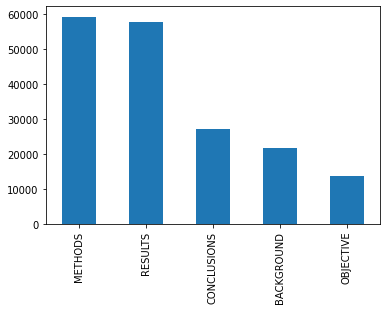

In [ ]:
# check out distribution of labels in training data
train_df.target.value_counts().plot(kind = "bar")

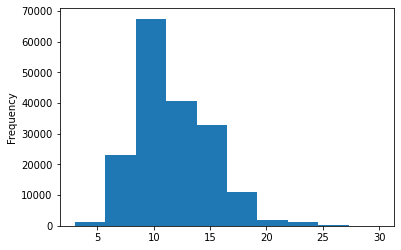

In [ ]:
# lets check the length of different lines
train_df.total_lines.plot(kind = "hist")

### Get a list of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

len(train_sentences) , len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# Viewing the 10 first lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

ML models requires data, therefore it is necessary to bring labels to numerical value for any model to work.

We shall one-hot-encode or label-encode it upto our requirements

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Encode Labels

In [ ]:
# Extract labels ("target", columns) & encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded =  label_encoder.transform(test_df["target"].to_numpy())

# check what trainign labels lookc like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class name & number of classes from label_encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Creating a series of model experiments

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in <a href="https://arxiv.org/pdf/1612.05251.pdf">Neural networks for joint sentence classification in medical paper abstracts.</a>

For each model, we'll train it on the training data and evaluate it on the validation data.

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf",MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences,
            train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper function script

We've created helper functions to evaluate certain criterions already. We shall call them here from our helper_function scripts

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-01 08:58:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-01 08:58:15 (45.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing the text into numeric format for deep sequence models

Before we start building deeper models, we've gotta create vectorization and embedding layers.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers


In [ ]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

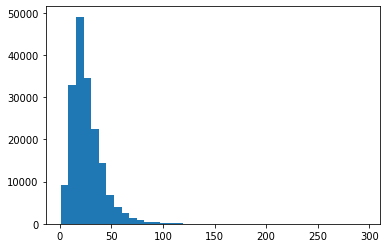

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 40);

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)  # We can use this for padding

296

### Create a text vectorizer layer

We will now tokenize our layer in order to allow our deep learning model to function.

We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence)

In [ ]:
# How many words are in our vocabulary? (taken from table 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
# Create a text vectorizer 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens, # number of vocab words
                                    output_sequence_length = output_seq_len) # max output seq length

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# We should be able to map our text_vectorizer to random sentences
import random
ts = random.choice(train_sentences)
print(f"Text:\n{ts}")
print(f"\nLength of text: {len(ts)}")
print(f"\nVectorizes text: {text_vectorizer([ts])}")

Text:
we performed a prospective randomized trial to compare the prevention of rebleeding in patients given a small-diameter covered stent vs those given hepatic venous pressure gradient ( hvpg ) - based medical therapy prophylaxis .

Length of text: 227

Vectorizes text: [[   43   153     8   241    29    32     6   226     2   403     4  6349
      5    12   330     8 28475  3535   788    44   125   330  1668  1120
    200  5571 20477   261   274    66  1392     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [ ]:
tf.random.set_seed(42)

token_embed = tf.keras.layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    mask_zero = True,
    name = "token_embedding"
)

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n{ts}\n")
vectorized_sentence = text_vectorizer([ts])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
we performed a prospective randomized trial to compare the prevention of rebleeding in patients given a small-diameter covered stent vs those given hepatic venous pressure gradient ( hvpg ) - based medical therapy prophylaxis .

Sentence after vectorization (before embedding):
[[   43   153     8   241    29    32     6   226     2   403     4  6349
      5    12   330     8 28475  3535   788    44   125   330  1668  1120
    200  5571 20477   261   274    66  1392     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.01617707  0.0422763   0.00466955 ...  0.0381538   0.03315575
    0.04610637]
  [ 0.01219778  0.01619141  0.04948029 ... -0.0021206   0.01735406
   -0.03736313]
  [ 0.03494309  0.02677599 -0.01469069 ... -0.00333368 -0.02596296
   -0.02523291]
  ...
  [ 0.01645621 -0.00589932 -0.01471175 ... -0.02511839  0.00912381


### Creating datasets

Making sure our data works as fast as possible.

We're going to setup our data to fast with the TensorFlow `tf.data API`.

The many steps are discussed in these resources
* https://www.tensorflow.org/guide/data
* https://www.tensorflow.org/guide/data_performance


To create a batched PrefetchDataset we can use the methods `batch()` and `prefetch()`, the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [ ]:
# Turn our data into tensorflow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Take TensorSliceDatasets for prefetching and batching
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:


```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

We're also going to be following the standard machine learning workflow of:

1. Build model
2. Train model
3. Evaluate model (make predictions and compare to ground truth)

In [ ]:
# Create a 1dconv model
from tensorflow.keras import layers

inputs =layers.Input(shape = (1,) , dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5,
                  padding = "same" ,
                  activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation = "softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 14ms/step - loss: 0.9244 - accuracy: 0.6357 - val_loss: 0.6867 - val_accuracy: 0.7350
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6558 - accuracy: 0.7597 - val_loss: 0.6295 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6158 - accuracy: 0.7766 - val_loss: 0.5955 - val_accuracy: 0.7852


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5966 - accuracy: 0.7871


[0.5966249704360962, 0.7871044874191284]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.74069744e-01, 1.38163567e-01, 6.08098917e-02, 3.04589629e-01,
        2.23671421e-02],
       [4.00980830e-01, 3.06028128e-01, 1.35317994e-02, 2.69141585e-01,
        1.03176851e-02],
       [1.22885615e-01, 6.25555729e-03, 1.94572762e-03, 8.68862271e-01,
        5.08944104e-05],
       ...,
       [6.40450025e-06, 1.00070133e-03, 6.34980795e-04, 2.82502606e-06,
        9.98355091e-01],
       [5.47301285e-02, 4.65130091e-01, 9.59560275e-02, 6.21256977e-02,
        3.22058082e-01],
       [1.97692707e-01, 6.62739992e-01, 3.79333198e-02, 5.55241741e-02,
        4.61098701e-02]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.7104461803257,
 'f1': 0.7848466007009609,
 'precision': 0.7840175240686577,
 'recall': 0.787104461803257}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## MODEL 2 : Feature Extraction with Pretrained Token Embeddings

Since we're moving towards replicating the model architecture in <a href="https://arxiv.org/pdf/1612.05251.pdf">Neural Networks for Joint Sentence Classification in Medical Paper Abstracts</a>, it mentions they used a <a href="https://nlp.stanford.edu/projects/glove/">pretrained GloVe embedding</a> as a way to initialise their token embeddings.


```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder)
-> Layers -> Output (prediction probabilities)
```
We'll keep the pretrained embeddings frozen (by setting trainable=False) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")

In [ ]:
# test out the pretained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")


Random Sentence:
 we utilised a central telephone randomisation server , with computer generated schedule , balanced variable blocks , and stratification for parity , body mass index ( bmi ) category , and hospital .
Sentence after embedding:
[-0.06897639 -0.04101325 -0.06657168  0.05624155  0.04429299 -0.03866562
 -0.00674007  0.05189421  0.07103933  0.01558671  0.07198782  0.00356091
 -0.03723431  0.03725687 -0.03705939  0.00734056 -0.07344751  0.0293959
 -0.05948345 -0.04407661  0.00541534  0.00247114  0.02801136 -0.04549736
  0.06233611 -0.02013312 -0.07155157  0.06499723  0.02249418 -0.07210974] (truncated output)...

Length of sentence embedding:
512


### Building and fitting an NLP feature extraction model from TensorFlow Hub


In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape = [], dtype = tf.string)
pretrained_embed = tf_hub_embedding_layer(inputs) # Tokenize text automatically and create 512Vectors of sequences
x = layers.Dense(128, activation = "relu")(pretrained_embed)
outputs = layers.Dense(5, activation = "softmax")(x)

model_2 = tf.keras.Model(inputs, outputs,
                         name = "model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer ="Adam",
                metrics = ["accuracy"])

# Get a summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 25s 35ms/step - loss: 0.9198 - accuracy: 0.6495 - val_loss: 0.7978 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7697 - accuracy: 0.7010 - val_loss: 0.7575 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7525 - accuracy: 0.7134 - val_loss: 0.7405 - val_accuracy: 0.7138


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 27s 28ms/step - loss: 0.7413 - accuracy: 0.7141


[0.7413357496261597, 0.7140871286392212]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_pred_probs,axis =1)

In [ ]:
# calculate results
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)
model_2_results

{'accuracy': 71.40871177015755,
 'f1': 0.7110541449092921,
 'precision': 0.7141922798471265,
 'recall': 0.7140871177015755}

## Model 3 : Conv1D with character embeddings

The paper we're replicating uses hybrid token and character embedding.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the `TextVectorization` class and then passing those vectorized sequences through an `Embedding layer`.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

Our current textvectorizer works on a word level. We need to first split our data into characters in order and then use it on characters.

In [ ]:
def split_function(data):
  return " ".join(list(data))

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_function(sentence) for sentence in train_sentences]
val_chars = [split_function(sentence) for sentence in val_sentences]
test_chars = [split_function(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# Check out average length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

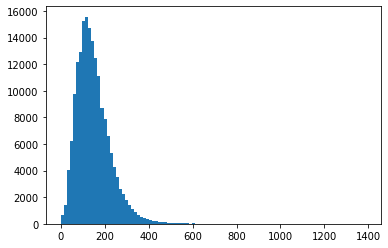

In [ ]:
# Check out the character distribution
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 100);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alpha = string.ascii_lowercase + string.digits + string.punctuation
alpha , len(alpha) # Can be used for creating char vectors

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alpha) + 2 # For UNK AND SPACE TOKEN
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    #standardize = None,
                                    name = "char_vectorizer")

In [ ]:
# adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
d u r i n g   t h e   o r a l   f a t   l o a d   t e s t   ,   i n t e r l e u k i n - @   ,   h i g h - s e n s i t i v i t y   c - r e a c t i v e   p r o t e i n   a n d   t u m o u r   n e c r o s i s   f a c t o r   -   p e a k s   w e r e   l o w e r   a n d   a d i p o n e c t i n   p e a k   w a s   h i g h e r   i n   t h e   v i l d a g l i p t i n   g r o u p   t h a n   i n   t h e   g l i m e p i r i d e   g r o u p   .

Length of chars: 185

Vectorized chars:
[[10 16  8  4  6 18  3 13  2  7  8  5 12 17  5  3 12  7  5 10  3  2  9  3
   4  6  3  2  8 12  2 16 23  4  6 13  4 18 13  9  2  6  9  4  3  4 21  4
   3 19 11  8  2  5 11  3  4 21  2 14  8  7  3  2  4  6  5  6 10  3 16 15
   7 16  8  6  2 11  8  7  9  4  9 17  5 11  3  7  8 14  2  5 23  9 20  2
   8  2 12  7 20  2  8  5  6 10  5 10  4 14  7  6  2 11  3  4  6 14  2  5
  23 20  5  9 13  4 18 13  2  8  4  6  3 13  2 21  4 12 10  5 18 12  4 14
   3  4  6 18  8  7 16 14  3 13  5  6  4  6  3 13  2 18 12  4

### Creating a character level embedding

We will use 25 output dim just like the paper for out output vector and mask all the zeroes

In [ ]:
char_embed = layers.Embedding(input_dim = 28, # Len(char_vocab)
                              output_dim = 25,
                              mask_zero = True,
                              name = "char_embed")

In [ ]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
d u r i n g   t h e   o r a l   f a t   l o a d   t e s t   ,   i n t e r l e u k i n - @   ,   h i g h - s e n s i t i v i t y   c - r e a c t i v e   p r o t e i n   a n d   t u m o u r   n e c r o s i s   f a c t o r   -   p e a k s   w e r e   l o w e r   a n d   a d i p o n e c t i n   p e a k   w a s   h i g h e r   i n   t h e   v i l d a g l i p t i n   g r o u p   t h a n   i n   t h e   g l i m e p i r i d e   g r o u p   .

Embedded chars (after vectorization and embedding):
[[[ 0.01616779 -0.02746451  0.01698602 ...  0.02823604  0.04332602
   -0.01149365]
  [ 0.00593116  0.00218263  0.03109694 ... -0.00562006 -0.0022221
   -0.03815103]
  [ 0.04262446  0.02685023 -0.03411337 ...  0.04522467 -0.01009031
    0.02774758]
  ...
  [-0.00644445  0.00248653 -0.00032532 ...  0.03155345  0.03697617
   -0.03122803]
  [-0.00644445  0.00248653 -0.00032532 ...  0.03155345  0.03697617
   -0.03122803]
  [-0.00644445  0.00248653 -0.000325

### Building a Conv1D model to fit on character embeddings

```
Input (character-level text) -> Tokenize -> Embedding
-> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)
```

In [ ]:
# Make Conv1D on char-dataset
inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, padding="same",
                  kernel_size = 5, activation = "relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation = "softmax")(x)

model_3 = tf.keras.Model(inputs, outputs,name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Check the summary
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None, 5

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 17ms/step - loss: 1.2696 - accuracy: 0.4902 - val_loss: 1.0509 - val_accuracy: 0.5855
Epoch 2/3
562/562 [==============================] - 10s 17ms/step - loss: 1.0134 - accuracy: 0.5975 - val_loss: 0.9584 - val_accuracy: 0.6257
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.9249 - accuracy: 0.6406 - val_loss: 0.8875 - val_accuracy: 0.6609


In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

5627/5627 [==============================] - 40s 7ms/step - loss: 0.8935 - accuracy: 0.6553


[0.8935185670852661, 0.6552988290786743]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)


In [ ]:
model_3_results = {'accuracy': 65.87779690189329,
 'f1': 0.6516863332082763,
 'precision': 0.6545009464773592,
 'recall': 0.6587779690189329}

## Model 4 : Combining pretrained token embeddings + characters embeddings (hybrid embed layer)

1. Create a token level embedding model like `model_1`
2. Create a character level model like `model_3` with slight modification
3. Combine 1 & 2 with `layers.Concatenate`
4. Build a series of output layers on 3. 
5. Construct a model which takes token and character level sequences as inputs and produces sequence label probabilities as outputs

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

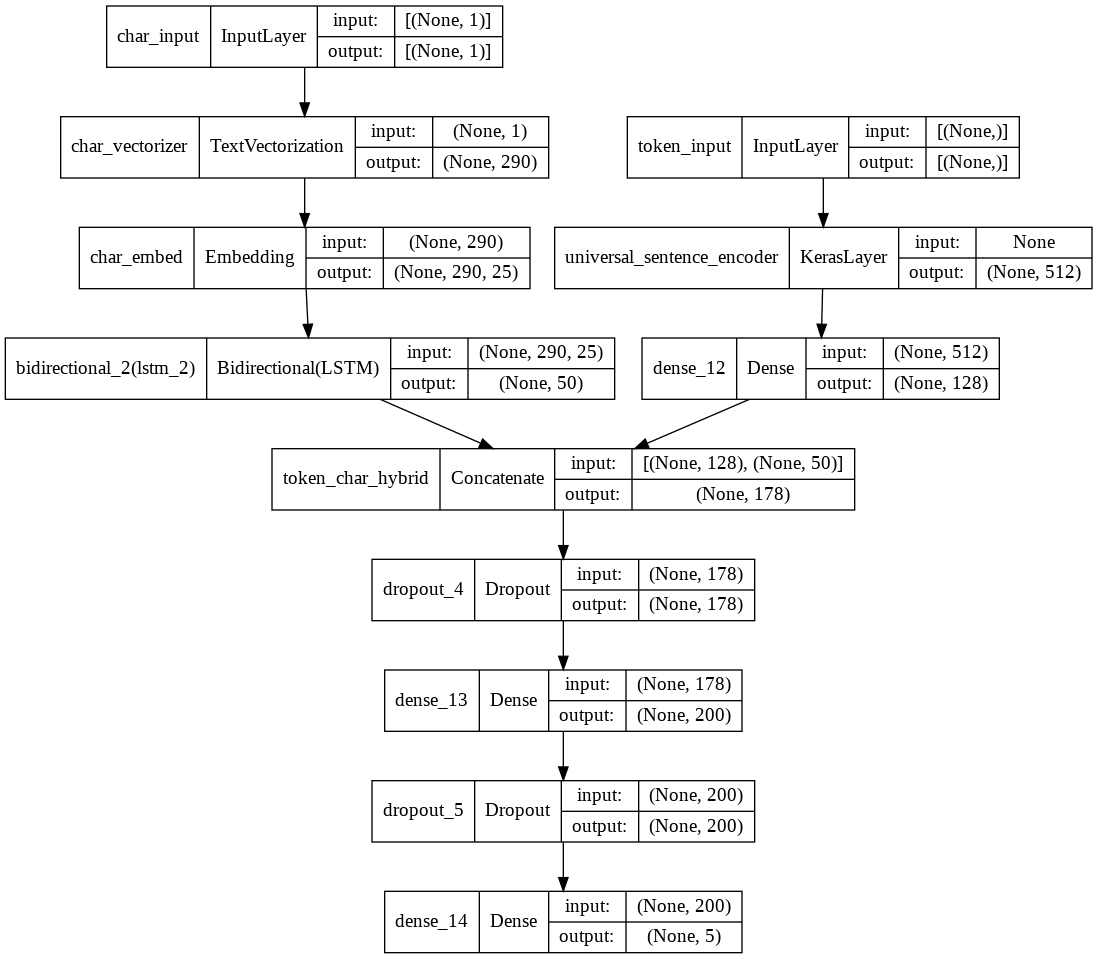

In [ ]:
# Plot the model

from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [ ]:
# Compile the token char model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

### Combining token and character data into a tf.data dataset

We can do this by create a `tf.data.Dataset` with a tuple as it's first input, for example:

`((token_data, char_data), (label))`

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting a model on token and character level sequences

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 87s 135ms/step - loss: 0.9664 - accuracy: 0.6107 - val_loss: 0.7846 - val_accuracy: 0.6975
Epoch 2/3
562/562 [==============================] - 73s 129ms/step - loss: 0.7868 - accuracy: 0.6971 - val_loss: 0.7046 - val_accuracy: 0.7334
Epoch 3/3
562/562 [==============================] - 69s 122ms/step - loss: 0.7640 - accuracy: 0.7090 - val_loss: 0.6788 - val_accuracy: 0.7377


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 63s 67ms/step - loss: 0.6827 - accuracy: 0.7385


[0.6827148199081421, 0.7384814023971558]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.84813981199522,
 'f1': 0.7351388556843639,
 'precision': 0.7371573857399364,
 'recall': 0.7384813981199523}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df[train_df.target == "OBJECTIVE"][train_df["line_number"] > 2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,target,text,line_number,total_lines
15,OBJECTIVE,it was expected that emotional eating is predi...,3,10
58,OBJECTIVE,the aim of this study was to test whether imme...,3,11
230,OBJECTIVE,to assess the presence of placebo effect in ne...,3,14
300,OBJECTIVE,this is the first-time use of montelukast in p...,3,15
442,OBJECTIVE,we quantified the requirements for isoleucine ...,3,9
...,...,...,...,...
178707,OBJECTIVE,our aim was to explore the blood oxygen level-...,3,11
179449,OBJECTIVE,the main objective of the present study was to...,3,9
179968,OBJECTIVE,the primary study outcome is the difference in...,8,12
179969,OBJECTIVE,secondary outcomes include mean reduction in b...,9,12


> NOTE : Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create Positional Embeddings 

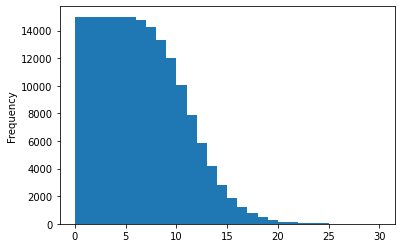

In [ ]:
# How many different line numbers are there?
train_df["line_number"].plot(kind="hist" , bins = 30)

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth = 15)

train_line_numbers_one_hot[:14] ,train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, lets do the same for our total lines features...

In [ ]:
# How many different numbers of lines are there
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

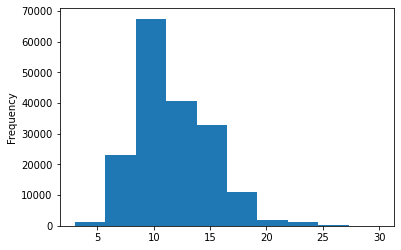

In [ ]:
# check the distributions of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of total_lines features

train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth = 20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Create a token level model
2. Create a char level model
3. Create a model for  the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combined the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3,4,5 using tf.`keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and produce output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model`

In [ ]:
# 1. Token inputs

token_inputs = layers.Input(shape = [], dtype = tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1,), dtype = tf.string,name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. line_number model
line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32, name="line_number_input")
x = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs =x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32 , name="total_lines_input")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "char_token_hybrid_embed")([token_model.output,
                                                                            char_model.output])
z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedddings with combined total and char embeddings

tribrid_embeddings = layers.Concatenate(name = "tribrid_embed")([line_number_model.output,
                                                                 total_lines_model.output,
                                                                 z])

# 7. Create output layer 
output_layer = layers.Dense(5, activation = "softmax", name = "output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = "tribrid_model_5")


In [ ]:
# Get a summary
model_5.summary()

Model: "tribrid_model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0

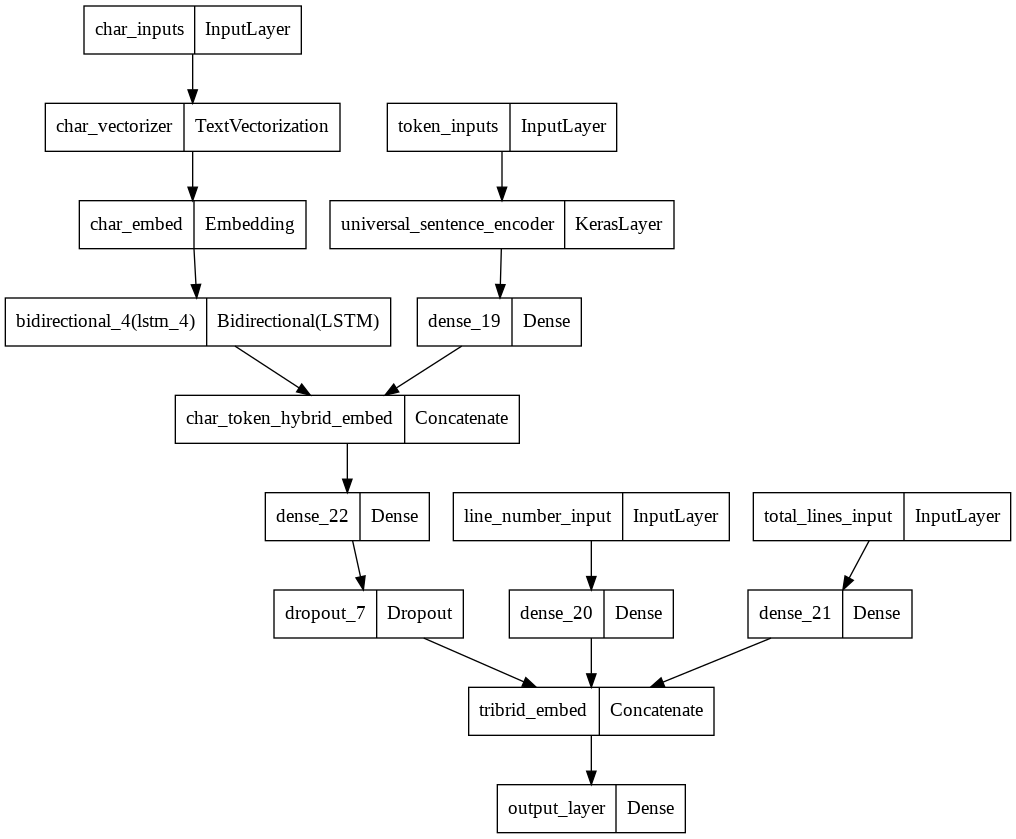

In [ ]:
plot_model(model_5)

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

If the prediction probability of a model on a single class is extremely high then it may be overfitting and not being able to consider other classes.

Really Confident : `[0.0,0.0,1.0,0.0,0.0]`

What `label smoothing` does is to assign some of the value from the highest pred prob to other classes in turn of improving generalization

`[0.01,0.01,0.96,0.01,0.01]`

>For more on label smoothing, see this blog post on pyimgsearch : https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

### Create Tribrid embedding datasets using tf.data

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset


(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

### Fitting, evaluating and making predictions with our tribrid model


In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 74s 132ms/step - loss: 0.9290 - accuracy: 0.8431 - val_loss: 0.9393 - val_accuracy: 0.8321
Epoch 2/3
562/562 [==============================] - 74s 132ms/step - loss: 0.9267 - accuracy: 0.8434 - val_loss: 0.9292 - val_accuracy: 0.8424
Epoch 3/3
562/562 [==============================] - 69s 123ms/step - loss: 0.9327 - accuracy: 0.8340 - val_loss: 0.9271 - val_accuracy: 0.8388


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

945/945 [==============================] - 52s 51ms/step


{'accuracy': 84.35389911293527,
 'f1': 0.8428031228338961,
 'precision': 0.8429871193433562,
 'recall': 0.8435389911293526}

## Compare model results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.710446,0.784018,0.787104,0.784847
pretrained_token_embed,71.408712,0.714192,0.714087,0.711054
custom_char_embed_conv1d,65.877797,0.654501,0.658778,0.651686
hybrid_char_token_embed,73.848140,0.737157,0.738481,0.735139
tribrid_pos_char_token_embed,84.353899,0.842987,0.843539,0.842803


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

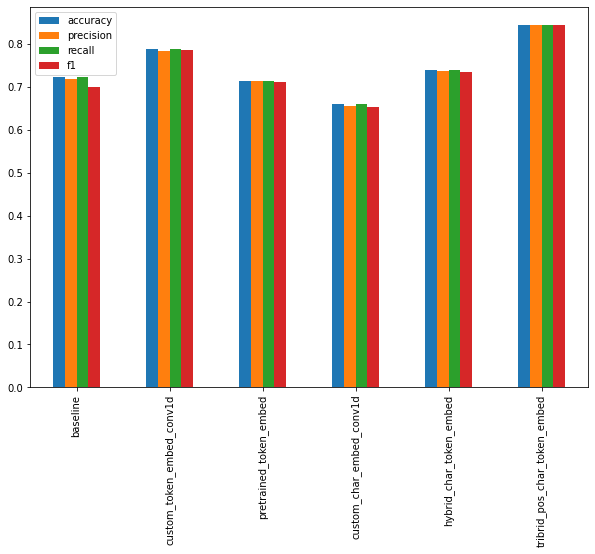

In [ ]:
all_model_results.plot(kind="bar" , figsize=(10,7))

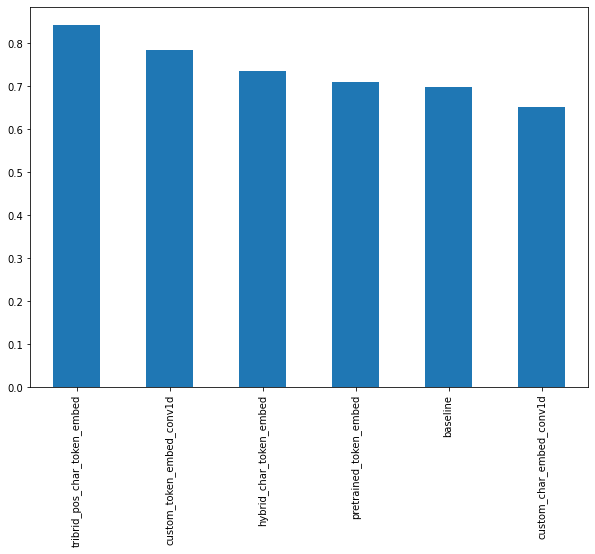

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [ ]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

ValueError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp skimlit_tribrid_model -r /content/drive/MyDrive/skim_lit